#1. GRU encoder-decoder with attention (no pre-training)

The following architecture is composed of of a GRU encoder and a GRU decoder, with the addition of an attention layer. We use MLP attention computing the energy score $s_i$ with the formula $s_i = a^T tanh (W_d d_t + W_s h_i)$.  Rather than using a vocabulary of pre-trained embeddings, we randomly initialise an embedding layer which is progressively tuned during training. The dimension of the embedding layer is 300. We use a batch size of 32 samples, Adam optimiser with a learning rate of 0.001, and cross-entropy loss (from which we calculate the perplexity scores by taking the exponential). We also implement dropout (value 0.5) to limit overfitting. The models have ~20 million tunable parameters. Both models are trained for 100 epochs.

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import statements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.data import Field, BucketIterator, Example, LabelField
from torch.utils.data import Dataset

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

import re

import unicodedata
from collections import Counter

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#set seed
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
#remove limits to read all the text in the dataframe
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

##1a) Non-empathetic response as input

In [ ]:
#import csv data file into pandas dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

In [ ]:
#add start and end-of-sentence tokens to source and target strings
data_df['source'] = 'START ' + data_df['source'].astype(str) + ' END'
data_df['target'] = 'START ' + data_df['target'].astype(str) + ' END'

In [ ]:
#define functions

#convert unicode standard to ascii standard
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#generate a list of all words from the corpus
def vocab_gen( data_file ):

  text_list=[]
  word_list=[]

  for idx , text in enumerate( data_file ):

    text = unicodeToAscii(text.strip())
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)
    text=nltk.word_tokenize(text)
    #text = [word for word in text if not word in set(stopwords.words("english"))]
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    word_list.extend(text)
    text=" ".join(text)
    text_list.append(text)

  return word_list

word_src = vocab_gen( data_df.source )
word_trg = vocab_gen( data_df.target )

In [ ]:
#count occurrences of words and get vocabulary of unique tokens for source and target

word_counter_src = Counter(word_src)
vocab_src = sorted(word_counter_src  , key=word_counter_src.get, reverse=True)

word_counter_trg = Counter(word_trg)
vocab_trg = sorted(word_counter_trg  , key=word_counter_trg.get, reverse=True)

In [ ]:
#word to index lookup and viceversa
vocab_to_int_src = {word: ii   for ii, word in enumerate(vocab_src, 1)}
int_to_vocab_src = {ii : word  for ii , word in enumerate(vocab_src , 1)}

vocab_to_int_trg = {word: ii   for ii, word in enumerate(vocab_trg , 1)}
int_to_vocab_trg = {ii : word  for ii , word in enumerate(vocab_trg , 1)}

In [ ]:
#add pad token
def update_vocab( vocab_to_int , int_to_vocab ):

  vocab_to_int.update( {"<pad>":0} )
  #vocab_to_int.update( {"start":1} )
  #vocab_to_int.update( {"end":2} )

  int_to_vocab.update( {0 : "<pad>"} )
  #int_to_vocab.update( {1 : "start"} )
  #int_to_vocab.update( {2 : "end"} )

  return vocab_to_int , int_to_vocab

In [ ]:
vocab_to_int_src , int_to_vocab_src = update_vocab( vocab_to_int_src , int_to_vocab_src  )
vocab_to_int_trg , int_to_vocab_trg = update_vocab( vocab_to_int_trg , int_to_vocab_trg  )

In [ ]:
# extra preprocessing steps

#parameters for the dataset and dataloader
BATCH_SIZE = 32
max_sent_length= 150

def tokenize( i_text  , vocab ):

    text = unicodeToAscii(i_text.strip())
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)

    text=nltk.word_tokenize(text)
    #text = [word for word in text if not word in set(stopwords.words("english"))]
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)

    tokenize_sen =[]
    for i_word in text.split():
      tokenize_sen.append( vocab[ i_word ] )
    
    return np.array( tokenize_sen )


def preprocessing(df):

    source_sentences = df.source.values
    target_sentences = df.target.values

    
    
    encoded_source_sentences , encoded_target_sentences = [] , []
    for s_sent , t_sent in zip(source_sentences , target_sentences ):

        s_encoded_sent = tokenize( s_sent , vocab_to_int_src )[: max_sent_length ]
        
        t_encoded_sent = tokenize( t_sent , vocab_to_int_trg)[: max_sent_length]

        encoded_source_sentences.append(s_encoded_sent)
        encoded_target_sentences.append(t_encoded_sent)


    
    return encoded_source_sentences, encoded_target_sentences

In [ ]:
#split into train, val and test sets (80-10-10)
train_df, val_df, test_df = \
              np.split(data_df.sample(frac=1, random_state=42), 
                       [int(.8*len(data_df)), int(.9*len(data_df))])

In [ ]:
#preprocessing. Generate representation of sentences as arrays of vocab indexes
train_source_sentences, train_target_sentences = preprocessing(train_df)
val_source_sentences, val_target_sentences = preprocessing(val_df)
test_source_sentences, test_target_sentences = preprocessing(test_df)

In [ ]:
#define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Seq2SeqDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def attention_masks(self , encoded_sentences):
      # attention masks, 0 for padding, 1 for actual token
      attention_masks = []
      for sent in encoded_sentences:
          att_mask = [int(token_id > 0 ) for token_id in sent]
          attention_masks.append(att_mask)

      return attention_masks

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] 
        target_list = []
        mask_list = []

        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
        """
        
        # find the max sequence length from the batch
        max_batch_s_len = max(len(datum[0]) for datum in batch)
        max_batch_t_len = max(len(datum[1]) for datum in batch)

        max_batch_seq_len = max([max_batch_s_len , max_batch_t_len])

        if max_batch_seq_len > self.max_sent_length:
          max_batch_seq_len = self.max_sent_length

        # pad each of the texts in batch
        for datum in batch:
          padded_s_vec = np.pad(np.array(datum[0]),
                              pad_width = ((0, max_batch_seq_len - len(datum[0]))),
                              mode = "constant", constant_values = 0)
          
          padded_t_vec = np.pad(np.array(datum[1]),
                              pad_width = ((0, max_batch_seq_len - len(datum[1]))),
                              mode = "constant", constant_values = 0)
          
          #generate the attention mask
          #attention_mask = self.attention_masks([padded_vec])

          data_list.append(padded_s_vec)
          target_list.append( padded_t_vec )
          #mask_list.append(attention_mask[0])


        #convert to tensors
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.from_numpy(np.array(target_list))
        #mask_list = torch.from_numpy(np.array( mask_list))

        return [data_list, label_list]

In [ ]:
train_dataset = Seq2SeqDataset( train_source_sentences , train_target_sentences , max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)


valid_dataset = Seq2SeqDataset( val_source_sentences , val_target_sentences , train_dataset.max_sent_length)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)


test_dataset = Seq2SeqDataset( test_source_sentences , test_target_sentences , train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

In [ ]:
x , y = next(iter(valid_loader))

In [ ]:
#encoder class 
#randomly intialises embedding layer
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
#attention
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [ ]:
#decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
#model class (encoder + decoder)
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg , teacher_forcing_ratio = 0.5 , test_stage = False):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        if( test_stage ):
          outputs = torch.zeros(max_sent_length, batch_size, trg_vocab_size).to(self.device)
        else:
          trg_len = trg.shape[0]
          outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)

        if( test_stage ):
            input = torch.from_numpy( np.array([ vocab_to_int_src[ "start" ]  ]) ).view(batch_size).to(device)
            for t in range(1, max_sent_length ):
            
              #insert input token embedding, previous hidden state and all encoder hidden states
              #receive output tensor (predictions) and new hidden state
              output, hidden = self.decoder(input, hidden, encoder_outputs)
              
              #place predictions in a tensor holding predictions for each token
              outputs[t] = output
              
              #decide if we are going to use teacher forcing or not
              teacher_force = random.random() < teacher_forcing_ratio
              
              #get the highest predicted token from our predictions
              top1 = output.argmax(1) 
              
              #if teacher forcing, use actual next token as next input
              #if not, use predicted token
              input = trg[t] if teacher_force else top1

              i_word = int_to_vocab_trg[top1.detach().cpu().numpy()[0]]

              if(i_word == "END" ):
                break

            return outputs

        else:
            #first input to the decoder is the <sos> tokens
            input = trg[0,:]

            for t in range(1, trg_len):
                
                #insert input token embedding, previous hidden state and all encoder hidden states
                #receive output tensor (predictions) and new hidden state
                output, hidden = self.decoder(input, hidden, encoder_outputs)
                
                #place predictions in a tensor holding predictions for each token
                outputs[t] = output
                
                #decide if we are going to use teacher forcing or not
                teacher_force = random.random() < teacher_forcing_ratio
                
                #get the highest predicted token from our predictions
                top1 = output.argmax(1) 
                
                #if teacher forcing, use actual next token as next input
                #if not, use predicted token
                input = trg[t] if teacher_force else top1

            return outputs

In [ ]:
#hyperparams
INPUT_DIM = len( vocab_to_int_src )
OUTPUT_DIM = len( vocab_to_int_trg )
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
#initialise model weights
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4931, 300)
    (rnn): GRU(300, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5759, 300)
    (rnn): GRU(1324, 512)
    (fc_out): Linear(in_features=1836, out_features=5759, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
#display number of trainable parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,422,315 trainable parameters


In [ ]:
#define optimizer
optimizer = optim.Adam(model.parameters() , lr=0.001)

In [ ]:
#define loss function
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [ ]:
#train function
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, ( src , trg ) in enumerate(iterator):
        
        
        optimizer.zero_grad()
        # move to device
        src , trg = src.to(device) , trg.to(device)
        
        output = model(src, trg)
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
#evaluation
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#training loop

N_EPOCHS = 100
CLIP = 5

best_valid_loss = float('inf')

print("Training the model...")
tr = {'loss': [], 'PPL': []}
val = {'loss': [], 'PPL': []}
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader , optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader , criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/tut3-model-1a.pt')

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))
    
    if( (epoch+1)%5 == 0 ):
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Training the model...
Epoch: 05 | Time: 0m 10s
	Train Loss: 6.047 | Train PPL: 422.730
	 Val. Loss: 6.123 |  Val. PPL: 456.221
Epoch: 10 | Time: 0m 10s
	Train Loss: 6.002 | Train PPL: 404.422
	 Val. Loss: 6.126 |  Val. PPL: 457.520
Epoch: 15 | Time: 0m 10s
	Train Loss: 5.968 | Train PPL: 390.867
	 Val. Loss: 6.120 |  Val. PPL: 454.918
Epoch: 20 | Time: 0m 10s
	Train Loss: 5.947 | Train PPL: 382.435
	 Val. Loss: 6.124 |  Val. PPL: 456.461
Epoch: 25 | Time: 0m 10s
	Train Loss: 5.908 | Train PPL: 367.964
	 Val. Loss: 6.085 |  Val. PPL: 439.128
Epoch: 30 | Time: 0m 10s
	Train Loss: 5.856 | Train PPL: 349.348
	 Val. Loss: 6.046 |  Val. PPL: 422.367
Epoch: 35 | Time: 0m 10s
	Train Loss: 5.797 | Train PPL: 329.210
	 Val. Loss: 6.040 |  Val. PPL: 419.792
Epoch: 40 | Time: 0m 10s
	Train Loss: 5.742 | Train PPL: 311.603
	 Val. Loss: 6.028 |  Val. PPL: 414.834
Epoch: 45 | Time: 0m 10s
	Train Loss: 5.647 | Train PPL: 283.300
	 Val. Loss: 6.020 |  Val. PPL: 411.415
Epoch: 50 | Time: 0m 10s
	Train L

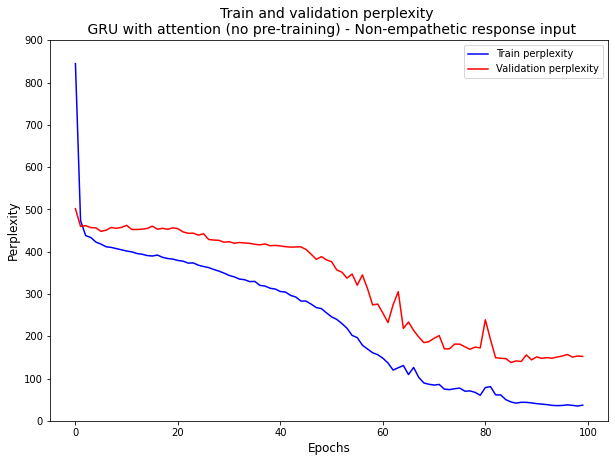

In [ ]:
#plot PPL curves for train and validation set

fig = plt.figure(figsize=(10,7))


y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(0, 900)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n GRU with attention (no pre-training) - Non-empathetic response input", fontsize = 14)

fig.savefig("1a-ppl.pdf")
plt.show()



In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/tut3-model-1a.pt'))

test_loss_1a = evaluate(model, test_loader , criterion)

print(f'| Test Loss: {test_loss_1a:.3f} | Test PPL: {math.exp(test_loss_1a):7.3f} |')

| Test Loss: 5.484 | Test PPL: 240.774 |


In [ ]:
#define functions to do a final visual evaluation on a subset of the test set

def int_2_words( i_text , vocab ) :

  text_list = []
  for i_idx in i_text :
    i_word =  vocab[i_idx] 

    if(i_word=='<pad>'):
      continue

    text_list.append( i_word )

    if(i_word=="END"):
      break

  text=" ".join(text_list)

  return text
  

def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[:,1:]
            trg = trg[:,1:]

            output = output.detach().cpu().numpy()
            trg = trg.detach().cpu().numpy()
            pred= np.argmax( output , axis = -1 )

            for i_pred , i_trg in zip( pred , trg  ):

              trg_sen = int_2_words( i_trg , int_to_vocab_trg  )
              pred_sen = int_2_words( i_pred , int_to_vocab_trg )

              print( "Target Sentence : {} \n".format( trg_sen )  )
              print( "Predicted Sentence : {} \n".format( pred_sen )  )

            break
      

In [ ]:
#test model on test set
generate_sentence(model, test_loader)

Target Sentence : Wow . It must have meant so much to give yourself to a relationship where that loss hurt this bad . Holy crap that s quite the level of commitment ! Well that is something to hang your hat on . You have that in you right ? You did it once before . Yea shit hurt right now but you have it in you ! ! .I cant imagine how happy you will be when you find the next one . . .maybe one that fit the possibility of a promising relationship ? Well I think you have a good base here . END 

Predicted Sentence :  

Target Sentence : I feel only bad thing too . I can laugh and joke with my buddy but it just feel hollow and empty on the inside . I even come to think that I often time smile and laugh cause I know a normal person would do this and I did it once so to don t look like a freak I do it at the right time . But I m never excited these day . I can t even remember the last time I wa . Even when I decided to lose my virginity to a prostitute when I wa around I had some concern bu

##1b) Seeker post + non-empathetic response as input

In [ ]:
#re-import csv data file into pandas dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

In [ ]:
#concatenate seeker_post and source. Concatenated sentences are separated by a SPLIT token
data_df["new_source"] = data_df["seeker_post"] + ' SPLIT ' + data_df["source"]

#drop unnecessary columns, rename, reorder
data_df = data_df.drop(['seeker_post', 'source'], axis=1)
data_df.rename(columns = {'new_source' : 'source'}, inplace = True)
data_df = data_df[['source', 'target']]

In [ ]:
#add start and end-of-sentence tokens
data_df['source'] = 'START ' + data_df['source'].astype(str) + ' END'
data_df['target'] = 'START ' + data_df['target'].astype(str) + ' END'

In [ ]:
#define functions

#convert unicode standard to ascii standard
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#generate a word list from the corpus
def vocab_gen( data_file ):

  text_list=[]
  word_list=[]

  for idx , text in enumerate( data_file ):

    text = unicodeToAscii(text.strip())
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)
    text=nltk.word_tokenize(text)
    #text = [word for word in text if not word in set(stopwords.words("english"))]
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    word_list.extend(text)
    text=" ".join(text)
    text_list.append(text)

  return word_list

word_src = vocab_gen( data_df.source )
word_trg = vocab_gen( data_df.target )

In [ ]:
#count words and make vocab of unique tokens
word_counter_src = Counter(word_src)
vocab_src = sorted(word_counter_src  , key=word_counter_src.get, reverse=True)

word_counter_trg = Counter(word_trg)
vocab_trg = sorted(word_counter_trg  , key=word_counter_trg.get, reverse=True)

In [ ]:
#word to index and viceversa
vocab_to_int_src = {word: ii   for ii, word in enumerate(vocab_src, 1)}
int_to_vocab_src = {ii : word  for ii , word in enumerate(vocab_src , 1)}

vocab_to_int_trg = {word: ii   for ii, word in enumerate(vocab_trg , 1)}
int_to_vocab_trg = {ii : word  for ii , word in enumerate(vocab_trg , 1)}

In [ ]:
#add pad token to vocab
def update_vocab( vocab_to_int , int_to_vocab ):

  vocab_to_int.update( {"<pad>":0} )
  #vocab_to_int.update( {"start":1} )
  #vocab_to_int.update( {"end":2} )

  int_to_vocab.update( {0 : "<pad>"} )
  #int_to_vocab.update( {1 : "start"} )
  #int_to_vocab.update( {2 : "end"} )

  return vocab_to_int , int_to_vocab

In [ ]:
vocab_to_int_src , int_to_vocab_src = update_vocab( vocab_to_int_src , int_to_vocab_src  )
vocab_to_int_trg , int_to_vocab_trg = update_vocab( vocab_to_int_trg , int_to_vocab_trg  )

In [ ]:
# extra preprocessing steps

#parameters for the dataset and dataloader
BATCH_SIZE = 32
max_sent_length= 150

def tokenize( i_text  , vocab ):

    text = unicodeToAscii(i_text.strip())
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)

    text=nltk.word_tokenize(text)
    #text = [word for word in text if not word in set(stopwords.words("english"))]
    lemma=nltk.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)

    tokenize_sen =[]
    for i_word in text.split():
      tokenize_sen.append( vocab[ i_word ] )
    
    return np.array( tokenize_sen )


def preprocessing(df):

    source_sentences = df.source.values
    target_sentences = df.target.values

    
    
    encoded_source_sentences , encoded_target_sentences = [] , []
    for s_sent , t_sent in zip(source_sentences , target_sentences ):

        s_encoded_sent = tokenize( s_sent , vocab_to_int_src )[: max_sent_length ]
        
        t_encoded_sent = tokenize( t_sent , vocab_to_int_trg)[: max_sent_length]

        encoded_source_sentences.append(s_encoded_sent)
        encoded_target_sentences.append(t_encoded_sent)


    
    return encoded_source_sentences, encoded_target_sentences

In [ ]:
#split into train, val and test sets (80-10-10)
train_df, val_df, test_df = \
              np.split(data_df.sample(frac=1, random_state=42), 
                       [int(.8*len(data_df)), int(.9*len(data_df))])

In [ ]:
#preprocessing
train_source_sentences, train_target_sentences = preprocessing(train_df)
val_source_sentences, val_target_sentences = preprocessing(val_df)
test_source_sentences, test_target_sentences = preprocessing(test_df)

In [ ]:
#define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Seq2SeqDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 
        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def attention_masks(self , encoded_sentences):
      # attention masks, 0 for padding, 1 for actual token
      attention_masks = []
      for sent in encoded_sentences:
          att_mask = [int(token_id > 0 ) for token_id in sent]
          attention_masks.append(att_mask)

      return attention_masks

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] 
        target_list = []
        mask_list = []

        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
        """
        
        # find the max sequence length from the batch
        max_batch_s_len = max(len(datum[0]) for datum in batch)
        max_batch_t_len = max(len(datum[1]) for datum in batch)

        max_batch_seq_len = max(  [  max_batch_s_len , max_batch_t_len ] )

        if max_batch_seq_len > self.max_sent_length:
          max_batch_seq_len = self.max_sent_length

        # pad each of the texts in batch
        for datum in batch:
          padded_s_vec = np.pad(np.array(datum[0]),
                              pad_width = ((0, max_batch_seq_len - len(datum[0]))),
                              mode = "constant", constant_values = 0)
          
          padded_t_vec = np.pad(np.array(datum[1]),
                              pad_width = ((0, max_batch_seq_len - len(datum[1]))),
                              mode = "constant", constant_values = 0)
          
          #generate the attention mask
          #attention_mask = self.attention_masks( [padded_vec] )

          data_list.append(padded_s_vec)
          target_list.append( padded_t_vec )
          #mask_list.append( attention_mask[0] )


        # convert to tensors
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.from_numpy( np.array(target_list)  )
        #mask_list = torch.from_numpy(  np.array( mask_list ) )

        return [data_list, label_list]

In [ ]:
#make datasets and dataloaders
train_dataset = Seq2SeqDataset( train_source_sentences , train_target_sentences , max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)


valid_dataset = Seq2SeqDataset( val_source_sentences , val_target_sentences , train_dataset.max_sent_length)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)


test_dataset = Seq2SeqDataset( test_source_sentences , test_target_sentences , train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

In [ ]:
x , y = next(iter(valid_loader))

In [ ]:
#encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
#attention
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [ ]:
#decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [ ]:
#model class
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg , teacher_forcing_ratio = 0.5 , test_stage = False):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        if( test_stage ):
          outputs = torch.zeros(max_sent_length, batch_size, trg_vocab_size).to(self.device)
        else:
          trg_len = trg.shape[0]
          outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)

        if( test_stage ):
            input = torch.from_numpy( np.array([ vocab_to_int_src[ "start" ]  ]) ).view(batch_size).to(device)
            for t in range(1, max_sent_length ):
            
              #insert input token embedding, previous hidden state and all encoder hidden states
              #receive output tensor (predictions) and new hidden state
              output, hidden = self.decoder(input, hidden, encoder_outputs)
              
              #place predictions in a tensor holding predictions for each token
              outputs[t] = output
              
              #decide if we are going to use teacher forcing or not
              teacher_force = random.random() < teacher_forcing_ratio
              
              #get the highest predicted token from our predictions
              top1 = output.argmax(1) 
              
              #if teacher forcing, use actual next token as next input
              #if not, use predicted token
              input = trg[t] if teacher_force else top1

              i_word = int_to_vocab_trg[top1.detach().cpu().numpy()[0]]

              if(i_word == "END" ):
                break

            return outputs

        else:
            #first input to the decoder is the <sos> tokens
            input = trg[0,:]

            for t in range(1, trg_len):
                
                #insert input token embedding, previous hidden state and all encoder hidden states
                #receive output tensor (predictions) and new hidden state
                output, hidden = self.decoder(input, hidden, encoder_outputs)
                
                #place predictions in a tensor holding predictions for each token
                outputs[t] = output
                
                #decide if we are going to use teacher forcing or not
                teacher_force = random.random() < teacher_forcing_ratio
                
                #get the highest predicted token from our predictions
                top1 = output.argmax(1) 
                
                #if teacher forcing, use actual next token as next input
                #if not, use predicted token
                input = trg[t] if teacher_force else top1

            return outputs

In [ ]:
#define hyperparams
INPUT_DIM = len( vocab_to_int_src )
OUTPUT_DIM = len( vocab_to_int_trg )
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
#initialise weights
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6350, 300)
    (rnn): GRU(300, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5759, 300)
    (rnn): GRU(1324, 512)
    (fc_out): Linear(in_features=1836, out_features=5759, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
#display number of trainable params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,848,015 trainable parameters


In [ ]:
#define optimizer
optimizer = optim.Adam(model.parameters() , lr=0.001)

In [ ]:
#define loss
criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [ ]:
#train function
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, ( src , trg ) in enumerate(iterator):
        
        
        optimizer.zero_grad()
        # move to device
        src , trg = src.to(device) , trg.to(device)
        
        output = model(src, trg)
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
#evaluate on dev set function
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#training loop

N_EPOCHS = 100
CLIP = 5

best_valid_loss = float('inf')

print("Training the model...")
tr = {'loss': [], 'PPL': []}
val = {'loss': [], 'PPL': []}
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader , optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader , criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/tut3-model-1c.pt')

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))
    
    if( (epoch+1)%5 == 0 ):
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Training the model...
Epoch: 05 | Time: 0m 10s
	Train Loss: 6.051 | Train PPL: 424.621
	 Val. Loss: 6.119 |  Val. PPL: 454.457
Epoch: 10 | Time: 0m 10s
	Train Loss: 6.010 | Train PPL: 407.655
	 Val. Loss: 6.116 |  Val. PPL: 453.149
Epoch: 15 | Time: 0m 10s
	Train Loss: 5.978 | Train PPL: 394.689
	 Val. Loss: 6.149 |  Val. PPL: 468.239
Epoch: 20 | Time: 0m 10s
	Train Loss: 5.963 | Train PPL: 388.848
	 Val. Loss: 6.148 |  Val. PPL: 467.948
Epoch: 25 | Time: 0m 10s
	Train Loss: 5.934 | Train PPL: 377.740
	 Val. Loss: 6.150 |  Val. PPL: 468.780
Epoch: 30 | Time: 0m 10s
	Train Loss: 5.912 | Train PPL: 369.305
	 Val. Loss: 6.169 |  Val. PPL: 477.870
Epoch: 35 | Time: 0m 10s
	Train Loss: 5.893 | Train PPL: 362.613
	 Val. Loss: 6.159 |  Val. PPL: 473.030
Epoch: 40 | Time: 0m 10s
	Train Loss: 5.871 | Train PPL: 354.447
	 Val. Loss: 6.161 |  Val. PPL: 473.869
Epoch: 45 | Time: 0m 10s
	Train Loss: 5.851 | Train PPL: 347.566
	 Val. Loss: 6.131 |  Val. PPL: 459.920
Epoch: 50 | Time: 0m 10s
	Train L

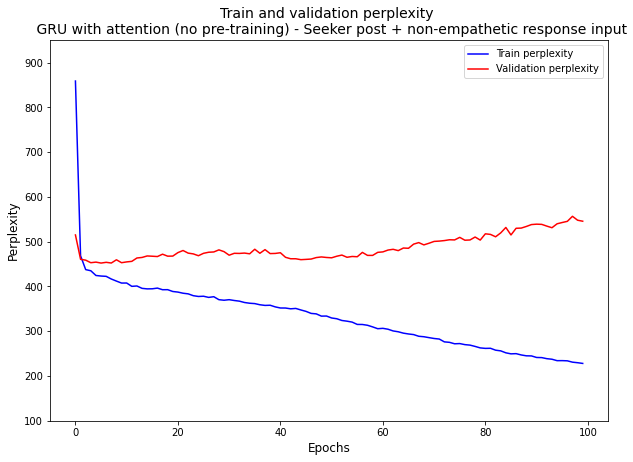

In [ ]:
#plot train and validation PPL logs

fig = plt.figure(figsize=(10,7))

y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(100, 950)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n GRU with attention (no pre-training) - Seeker post + non-empathetic response input", fontsize = 14)

fig.savefig("1b-ppl.pdf")
plt.show()

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/tut3-model-1c.pt'))

test_loss_1b = evaluate(model, test_loader , criterion)

print(f'| Test Loss: {test_loss_1b:.3f} | Test PPL: {math.exp(test_loss_1b):7.3f} |')

| Test Loss: 6.108 | Test PPL: 449.457 |


In [ ]:
#functions for human evaluation on test set

def int_2_words( i_text , vocab ) :

  text_list = []
  for i_idx in i_text :
    i_word =  vocab[i_idx] 

    if(i_word=='<pad>'):
      continue

    text_list.append( i_word )

    if(i_word=="END"):
      break

  text=" ".join(text_list)

  return text

def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (src , trg) in enumerate(iterator):

            #move to device
            src , trg = src.to(device) , trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[:,1:]
            trg = trg[:,1:]

            output = output.detach().cpu().numpy()
            trg = trg.detach().cpu().numpy()
            pred= np.argmax( output , axis = -1 )

            for i_pred , i_trg in zip( pred , trg  ):

              trg_sen = int_2_words( i_trg , int_to_vocab_trg  )
              pred_sen = int_2_words( i_pred , int_to_vocab_trg )

              print( "Target Sentence : {} \n".format( trg_sen )  )
              print( "Predicted Sentence : {} \n".format( pred_sen )  )

            break

In [ ]:
#evaluate on test set
generate_sentence(model, test_loader)